# Beef Regression Model with SARIMA
By Menard Gymer Rivera

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_excel('./data/beef_UN.xlsx')

In [3]:
Tilapia_DA = pd.read_excel('./data/beef_DA.xlsx')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,141,Meat (beef) - Retail,5,KG,5,2020,249.85
1,141,Meat (beef) - Retail,5,KG,5,2020,290.00
2,141,Meat (beef) - Retail,5,KG,5,2020,296.67
3,141,Meat (beef) - Retail,5,KG,5,2020,280.00
4,141,Meat (beef) - Retail,5,KG,5,2020,380.00
...,...,...,...,...,...,...,...
1129,141,Meat (beef) - Retail,5,KG,6,2021,337.50
1130,141,Meat (beef) - Retail,5,KG,6,2021,345.00
1131,141,Meat (beef) - Retail,5,KG,6,2021,386.25
1132,141,Meat (beef) - Retail,5,KG,6,2021,272.50


In [5]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,141.0,Meat (beef) - Retail,5.0,KG,5,2020,220.00
1,141.0,Meat (beef) - Retail,5.0,KG,5,2020,220.00
2,141.0,Meat (beef) - Retail,5.0,KG,5,2020,233.85
3,141.0,Meat (beef) - Retail,5.0,KG,5,2020,234.19
4,141.0,Meat (beef) - Retail,5.0,KG,5,2020,240.00


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,249.85,2020-05-15
1,290.00,2020-05-15
2,296.67,2020-05-15
3,280.00,2020-05-15
4,380.00,2020-05-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id','cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,mp_price,date
0,220.00,2020-05-15
1,220.00,2020-05-15
2,233.85,2020-05-15
3,234.19,2020-05-15
4,240.00,2020-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

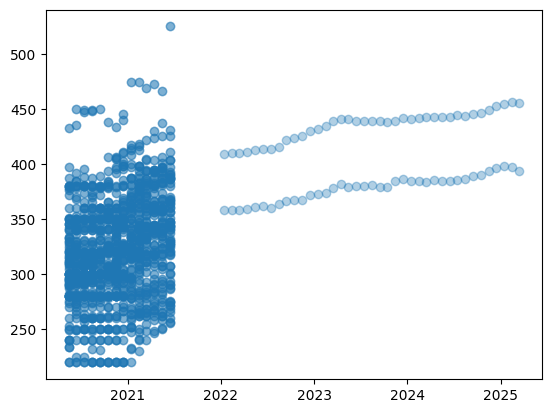

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
print("🕓 Index Range:")
print(f"Start: {Tilapia.index.min()}")
print(f"End:   {Tilapia.index.max()}")
print(f"Index type: {type(Tilapia.index)}\n")

🕓 Index Range:
Start: 2020-05-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [20]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

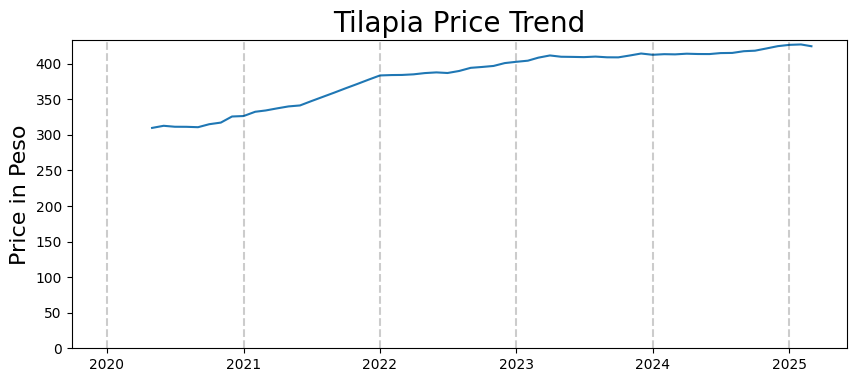

In [21]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [22]:
first_diff = lim_tilapia.diff()[1:]

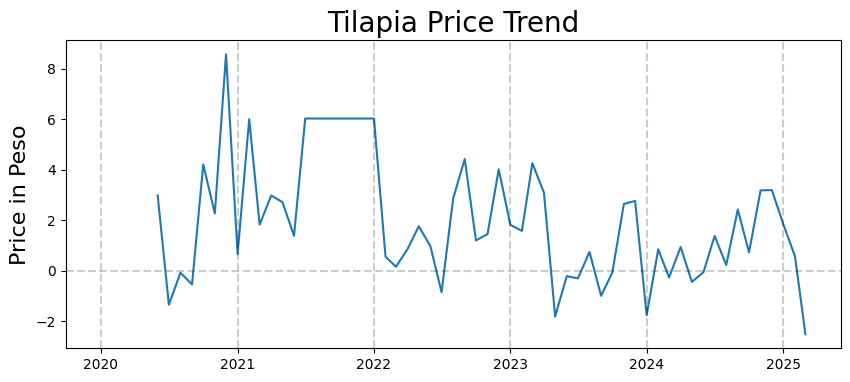

In [23]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [24]:
from statsmodels.tsa.stattools import acf, pacf

In [25]:
first_diff.columns

Index(['mp_price'], dtype='object')

In [26]:
first_diff.head()

,mp_price
date,
2020-06-01,2.977555
2020-07-01,-1.348256
2020-08-01,-0.082719
2020-09-01,-0.546340
2020-10-01,4.203639


<BarContainer object of 18 artists>

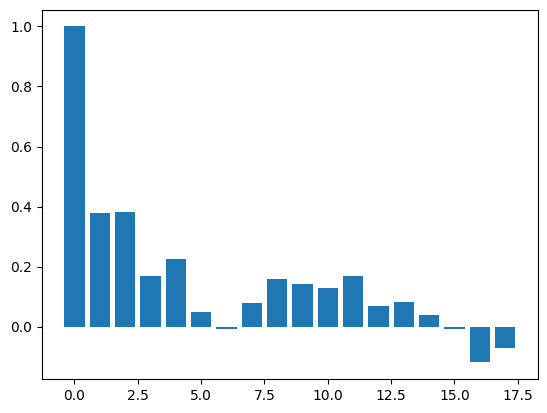

In [27]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

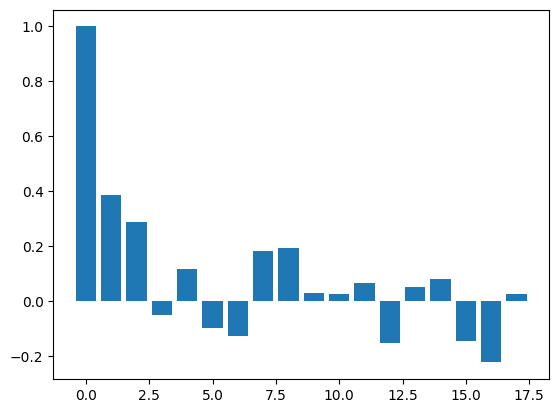

In [28]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [29]:
from datetime import timedelta

In [30]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [31]:
Tilapia.describe()

,mp_price
count,59.000000
mean,382.365874
std,37.832055
min,309.810566
25%,350.433046
50%,395.475000
75%,412.917500
max,427.145000


## Fit the SARIMA Model

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [33]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [34]:
from time import time

In [35]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.8019671440124512


In [36]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -129.167
Date:                              Wed, 21 May 2025   AIC                            264.334
Time:                                      01:02:34   BIC                            270.188
Sample:                                  05-01-2020   HQIC                           266.578
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9632      0.372      2.590      0.010       0.234       1.692
ma.S.L12      -0.78

In [37]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01   418.375
2024-11-01   421.555
2024-12-01   424.745
2025-01-01   426.575
2025-02-01   427.145


In [38]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [39]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [40]:
predictions

date
2024-10-01    419.453036
2024-11-01    421.622359
2024-12-01    425.228571
2025-01-01    426.248580
2025-02-01    427.705614
2025-03-01    428.734058
Freq: MS, Name: predicted_mean, dtype: float64

In [41]:
residuals

date
2024-10-01   -1.078036
2024-11-01   -0.067359
2024-12-01   -0.483571
2025-01-01    0.326420
2025-02-01   -0.560614
2025-03-01   -4.109058
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

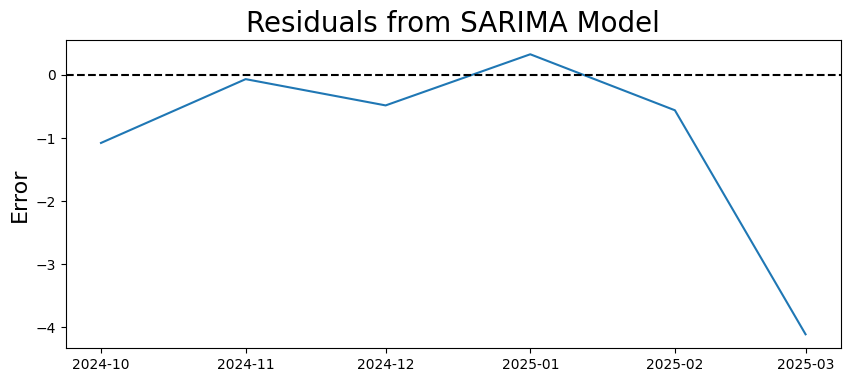

In [42]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

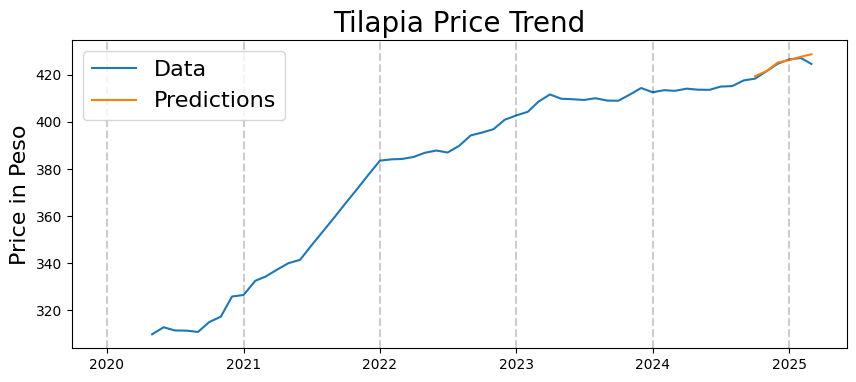

In [43]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [44]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data['mp_price'], order=my_order, seasonal_order=my_seasonal_order)

    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/tmp/ipykernel_46961/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_46961/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_46961/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_46961/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_46961/2302120164.py:9: FutureWarning: Calling float on a single element Series is deprecated and will

In [45]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

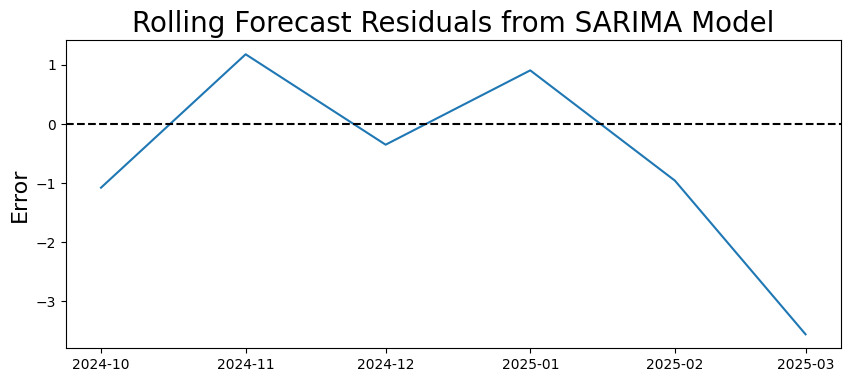

In [46]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

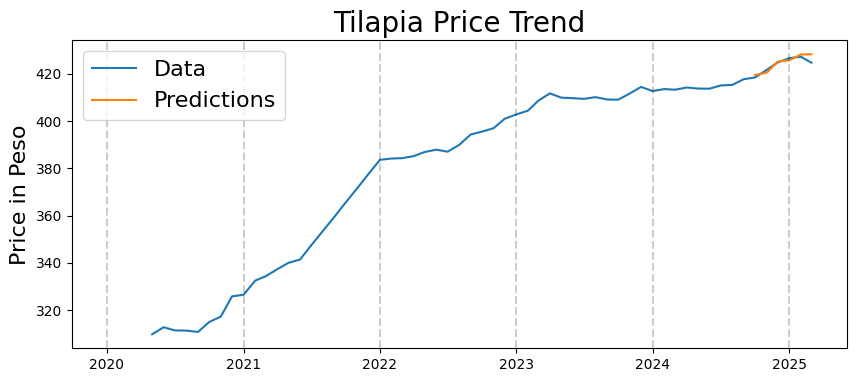

In [47]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [48]:
import numpy as np

In [49]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.0032


In [50]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1.6877489863854767


## Future Predictions (2025)

# eefe 